# Long Short Term Memory Network (LSTM)

## Stock Price Prediction

Reference: https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

In [1]:
# Import dependencies

import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Read the dataset into a pandas dataframe
df1 = pd.read_csv('../../launchit.csv')
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,TCKR,sector,industry,country,growth_rate,target_median_price,target_mean_price,target_high_price
0,2019-12-19,11.000,11.96,10.50,10.70,10.70,89400.0,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,15.0,15.0,15.0
1,2019-12-20,10.808,12.49,9.25,9.65,9.65,503000.0,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,15.0,15.0,15.0
2,2019-12-23,8.790,8.79,7.25,7.81,7.81,117400.0,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,15.0,15.0,15.0
3,2019-12-24,7.500,7.64,6.00,6.41,6.41,102800.0,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,15.0,15.0,15.0
4,2019-12-26,6.420,7.72,6.42,7.41,7.41,78400.0,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,15.0,15.0,15.0


In [3]:
# Make a new copy of the dataset_train 
stock_data = df1.copy()

In [4]:
# Drop qualitative columns
stock_data = stock_data.drop(labels=['sector', 'industry', 'country', 'growth_rate', 'target_median_price', 'target_mean_price', 'target_high_price'], axis=1)
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,TCKR
0,2019-12-19,11.000,11.96,10.50,10.70,10.70,89400.0,INDO
1,2019-12-20,10.808,12.49,9.25,9.65,9.65,503000.0,INDO
2,2019-12-23,8.790,8.79,7.25,7.81,7.81,117400.0,INDO
3,2019-12-24,7.500,7.64,6.00,6.41,6.41,102800.0,INDO
4,2019-12-26,6.420,7.72,6.42,7.41,7.41,78400.0,INDO


In [5]:
# Isolate just 1 TCKR to attempt LSTM process
stock_data = stock_data[stock_data.TCKR == 'INDO']
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume,TCKR
0,2019-12-19,11.000,11.96,10.500,10.70,10.70,89400.0,INDO
1,2019-12-20,10.808,12.49,9.250,9.65,9.65,503000.0,INDO
2,2019-12-23,8.790,8.79,7.250,7.81,7.81,117400.0,INDO
3,2019-12-24,7.500,7.64,6.000,6.41,6.41,102800.0,INDO
4,2019-12-26,6.420,7.72,6.420,7.41,7.41,78400.0,INDO
...,...,...,...,...,...,...,...,...
721,2022-10-31,6.370,6.72,6.340,6.67,6.67,319600.0,INDO
722,2022-11-01,6.900,7.05,6.660,6.75,6.75,374500.0,INDO
723,2022-11-02,6.720,6.88,6.410,6.61,6.61,605100.0,INDO
724,2022-11-03,6.560,6.82,6.542,6.70,6.70,177700.0,INDO


In [6]:
import datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,TCKR
721,2022-10-31,6.37,6.72,6.340,6.67,6.67,319600.0,INDO
722,2022-11-01,6.90,7.05,6.660,6.75,6.75,374500.0,INDO
723,2022-11-02,6.72,6.88,6.410,6.61,6.61,605100.0,INDO
724,2022-11-03,6.56,6.82,6.542,6.70,6.70,177700.0,INDO
725,2022-11-04,7.12,7.28,6.640,6.99,6.99,567372.0,INDO


In [7]:
stock_data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
TCKR                 object
dtype: object

In [8]:
# Set the Date column as the index
stock_data = stock_data.set_index('Date')
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,TCKR
Date,,,,,,,
2019-12-19,11.000,11.96,10.50,10.70,10.70,89400.0,INDO
2019-12-20,10.808,12.49,9.25,9.65,9.65,503000.0,INDO
2019-12-23,8.790,8.79,7.25,7.81,7.81,117400.0,INDO
2019-12-24,7.500,7.64,6.00,6.41,6.41,102800.0,INDO
2019-12-26,6.420,7.72,6.42,7.41,7.41,78400.0,INDO


Text(0, 0.5, 'Prices ($)')

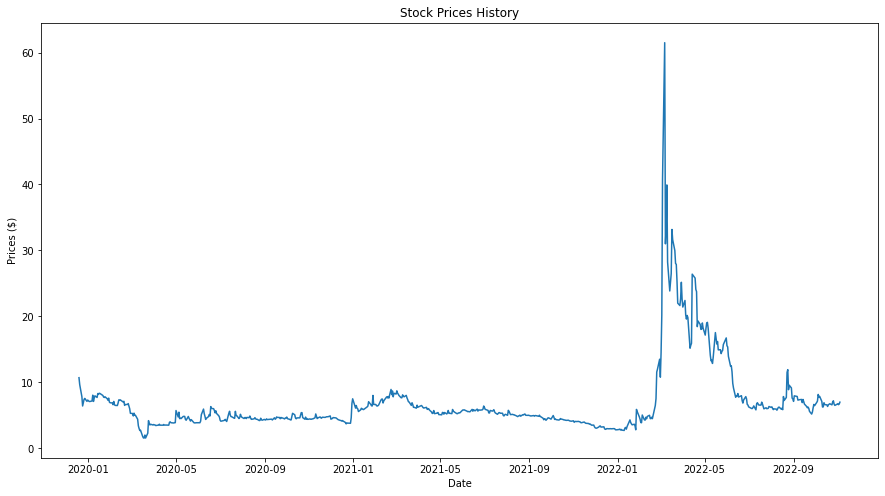

In [9]:
# Visualize stock prices history
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [10]:
# Prepare the training set
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
# Prepare the test set

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [12]:
# Setting up the LSTM Network Architecture
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
521/521 [==============================] - 29s 33ms/step - loss: 0.0037
Epoch 2/3
521/521 [==============================] - 22s 42ms/step - loss: 0.0035
Epoch 3/3
521/521 [==============================] - 20s 38ms/step - loss: 0.0024


In [14]:
# Evaluate the Model
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 3s 41ms/step


1.399521676425276

In [15]:
# Predictions
predictions

array([[15.318961 ],
       [14.158263 ],
       [13.136356 ],
       [12.539418 ],
       [14.733303 ],
       [17.083553 ],
       [18.38813  ],
       [18.87006  ],
       [17.679659 ],
       [16.47984  ],
       [15.477158 ],
       [14.656311 ],
       [14.15648  ],
       [14.140561 ],
       [14.131715 ],
       [13.895283 ],
       [13.902055 ],
       [14.182127 ],
       [14.504754 ],
       [14.549752 ],
       [13.533477 ],
       [12.273389 ],
       [11.314631 ],
       [10.631327 ],
       [10.475801 ],
       [11.438971 ],
       [12.322497 ],
       [12.729631 ],
       [12.947159 ],
       [12.737672 ],
       [12.443721 ],
       [12.062948 ],
       [11.842192 ],
       [11.768228 ],
       [11.978586 ],
       [12.463138 ],
       [12.626743 ],
       [12.593425 ],
       [12.165411 ],
       [11.37655  ],
       [10.710242 ],
       [10.068095 ],
       [ 9.229538 ],
       [ 8.414804 ],
       [ 7.5287585],
       [ 6.938455 ],
       [ 6.633929 ],
       [ 6.62

### Explore Visualization Set Up

In [16]:
data = stock_data.filter(['Close'])
data

,Close
Date,
2019-12-19,10.70
2019-12-20,9.65
2019-12-23,7.81
2019-12-24,6.41
2019-12-26,7.41
...,...
2022-10-31,6.67
2022-11-01,6.75
2022-11-02,6.61


In [17]:
train = data[:training_data_len]
train

,Close
Date,
2019-12-19,10.700000
2019-12-20,9.650000
2019-12-23,7.810000
2019-12-24,6.410000
2019-12-26,7.410000
...,...
2022-04-04,22.410000
2022-04-05,20.230000
2022-04-06,19.590000


In [18]:
validation = data[training_data_len:]
validation

,Close
Date,
2022-04-11,15.170000
2022-04-12,15.600000
2022-04-13,15.910000
2022-04-14,26.400000
2022-04-18,25.799999
...,...
2022-10-31,6.670000
2022-11-01,6.750000
2022-11-02,6.610000


In [19]:
validation['Predictions'] = predictions
predictions

C:\Users\Owner\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([[15.318961 ],
       [14.158263 ],
       [13.136356 ],
       [12.539418 ],
       [14.733303 ],
       [17.083553 ],
       [18.38813  ],
       [18.87006  ],
       [17.679659 ],
       [16.47984  ],
       [15.477158 ],
       [14.656311 ],
       [14.15648  ],
       [14.140561 ],
       [14.131715 ],
       [13.895283 ],
       [13.902055 ],
       [14.182127 ],
       [14.504754 ],
       [14.549752 ],
       [13.533477 ],
       [12.273389 ],
       [11.314631 ],
       [10.631327 ],
       [10.475801 ],
       [11.438971 ],
       [12.322497 ],
       [12.729631 ],
       [12.947159 ],
       [12.737672 ],
       [12.443721 ],
       [12.062948 ],
       [11.842192 ],
       [11.768228 ],
       [11.978586 ],
       [12.463138 ],
       [12.626743 ],
       [12.593425 ],
       [12.165411 ],
       [11.37655  ],
       [10.710242 ],
       [10.068095 ],
       [ 9.229538 ],
       [ 8.414804 ],
       [ 7.5287585],
       [ 6.938455 ],
       [ 6.633929 ],
       [ 6.62

C:\Users\Owner\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


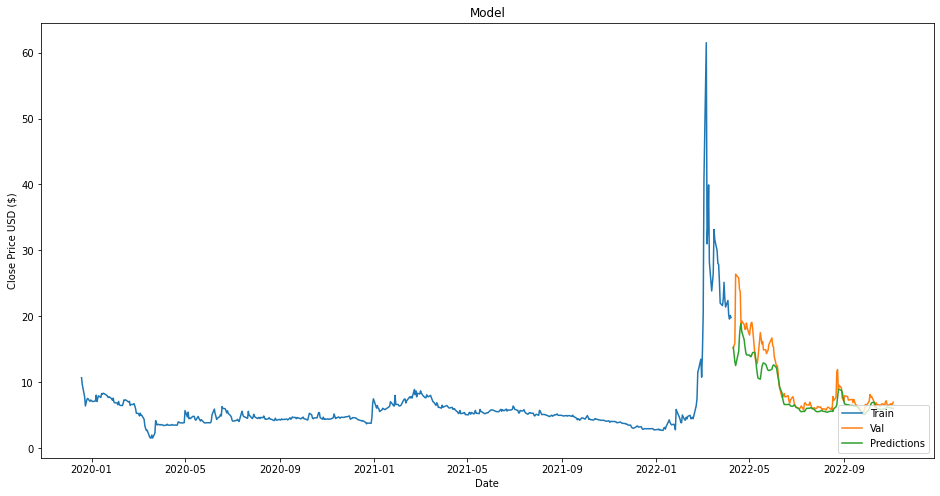

In [20]:
# Visualize the Predicted Prices
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()